##  Congratulations, you are now hired as a sport analytic. Your job is to give prediciton for the next Mathball tournament of the Six finest mathematicians in the world, which is a competition between Laplace, Gauss, Newton, Euler, Leibniz, Von-Neumann.

## The mathball is just like football where a player a goal is legal only after scoring you answer correctly a math question. 

## Motivation:  
### We want to infer a latent parameter - that is the 'strength' of a mathematician based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [82]:
# imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pickle as pkl

## The input   looks like as follows: 

In [83]:
group = 8
df_all  = pkl.load(open('../data_mathball/mathball_data_group_' + str(group)+ '.pkl', 'rb'))
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Newton,Leibniz,31,10,1897
1,Von-Neumann,Newton,29,6,1897
2,Von-Neumann,Leibniz,23,15,1897
3,Leibniz,Laplace,20,21,1897
4,Newton,Euler,26,24,1897


## We have home and away team, we have score and year. 

## What do we want to infer?

### We want to infer the latent parameters (every mathematian's strength) that are generating the data we observe (the scorelines).
### Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

## What do we want?

### We want to quantify our uncertainty
### We want to also use this to generate a model
### We want the answers as distributions not point estimates

## Part 1

### We next do some exploratory data analysis. The idea is to get a general sense of what is going on.

## Tasks

### 1. Plot a bar chart of the goal difference (i.e., total scored minus total scored against) per mathematician. Who is the best mathematician and who is the worst according to this plot?
### 2. Plot the same bar chart for each mathematician  as a function of time. Do you see a monote behvaoir which implies an improvement or the other way around for one of mathematician?
### 3. Choose your favorite mathematician, compare the goal difference between home and away games. Is he better in home or away games? Plot a bar chart of the goal difference for both home and away games.
### 4. Which mathematician has the best median away results? (that is, for each mathematician go over all of his away games, compute his scoring difference (how much he scored minues got scored against) and compute the median value). 

Euler is the best performer considering both home and away matches, on the opposite, Leibniz is the worst, with a goal difference poor in both home and away matches.

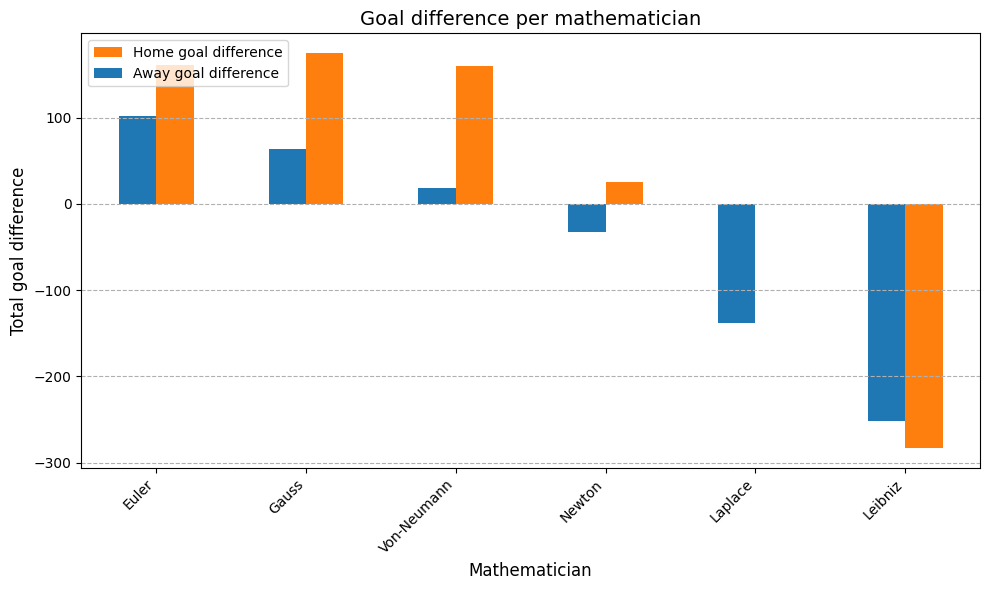

In [84]:
# Task 1

from matplotlib.patches import Patch

# Calculating goal difference per mathematician
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

# Group by mathematician and sum the goal difference
home_goal_diff = df_all.groupby('home_player')['home_goal_diff'].sum().reset_index()
away_goal_diff = df_all.groupby('away_player')['away_goal_diff'].sum().reset_index()
goal_diff = home_goal_diff.set_index('home_player').add(away_goal_diff.set_index('away_player'), fill_value=0)
goal_diff = goal_diff.sort_values(by='away_goal_diff', ascending=False) # Sorting by away goal difference

# The bar chart
goal_diff.plot(kind='bar', figsize=(10, 6))
plt.title('Goal difference per mathematician', fontsize=14)
plt.xlabel('Mathematician', fontsize=12)
plt.ylabel('Total goal difference', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
legend_elements = [Patch(facecolor='#ff7f0e', label='Home goal difference'),
                   Patch(facecolor='#1f77b4', label='Away goal difference')]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()
plt.show()

The only monote behaviour that the graph shows is the one from Laplace, he is consisten in its way to win the matches through the years. The rest of the players mantain a varying sum of the goal difference throught the years, which does not make them monote

<Figure size 1400x800 with 0 Axes>

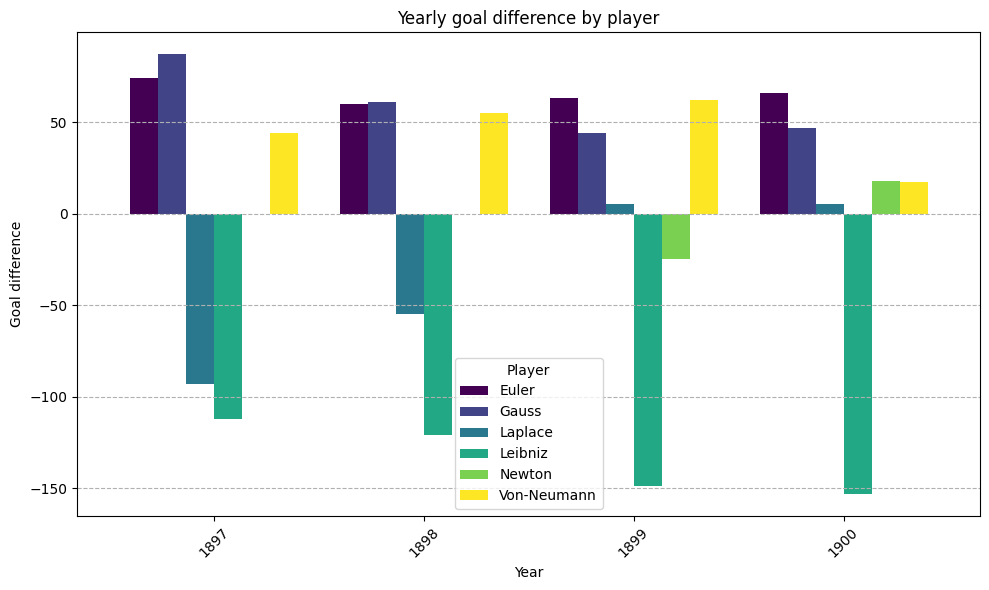

In [85]:
# Task 2

# Calculating the goal difference per year for each mathematician grouped by home and away players
df_all['year'] = pd.to_datetime(df_all['year'], format='%Y').dt.year
home_yearly_goal_diff = df_all.groupby(['home_player', 'year'])['home_goal_diff'].sum().reset_index()
away_yearly_goal_diff = df_all.groupby(['away_player', 'year'])['away_goal_diff'].sum().reset_index()
# Renaming columns
home_yearly_goal_diff.columns = ['player', 'year', 'goal_diff']
away_yearly_goal_diff.columns = ['player', 'year', 'goal_diff']

# Combining home and away goal differences and group by player and year to make the graph
yearly_goal_diff = pd.concat([home_yearly_goal_diff, away_yearly_goal_diff]).groupby(['player', 'year']).sum().reset_index()

# Unique players and years for plotting
players = yearly_goal_diff['player'].unique()
years = sorted(yearly_goal_diff['year'].unique())
n_players = len(players)
colors = plt.cm.rainbow(np.linspace(0, 1, n_players))  # Assigning a unique color to each player

# Graph
plt.figure(figsize=(14, 8))

# Pivot table of the DataFrame to get years as the index, players as columns, and goal differences as values and graph
pivoted_data = yearly_goal_diff.pivot(index='year', columns='player', values='goal_diff')
ax = pivoted_data.plot(kind='bar', width=0.8, figsize=(10, 6), colormap='viridis') # Plot of the pivoted data
plt.xticks(rotation=45)
plt.title('Yearly goal difference by player')
plt.xlabel('Year')
plt.ylabel('Goal difference')
plt.legend(title='Player')
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()

My favorite player, Euler, is better at home gamesn away games, based on the graph. The bar for the home goal difference is higher than the away bar

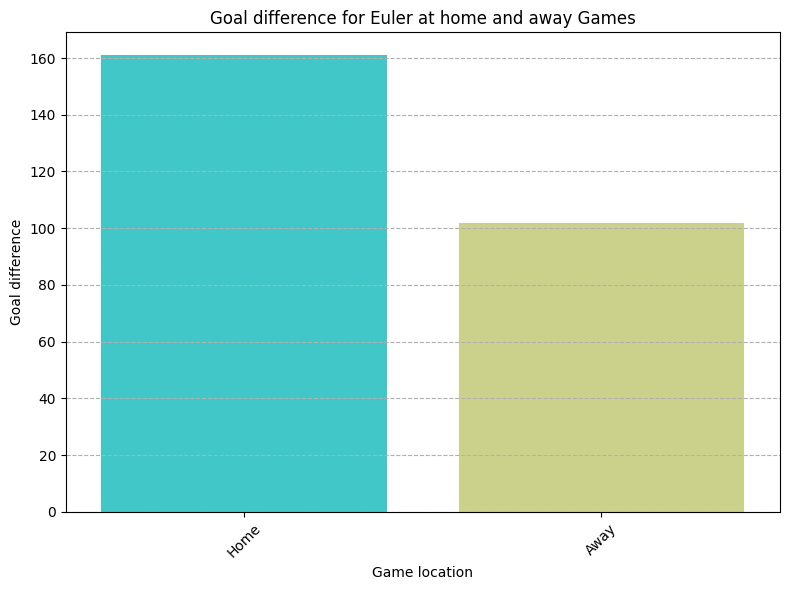

In [86]:
# Task 3

favorite_mathematician = 'Euler'

# Calculatibg home and away goal difference for the favorite mathematician
home_goal_diff_fav = df_all[df_all['home_player'] == favorite_mathematician]['home_goal_diff'].sum()
away_goal_diff_fav = df_all[df_all['away_player'] == favorite_mathematician]['away_goal_diff'].sum()

goal_diff_fav = pd.DataFrame({
    'Location': ['Home', 'Away'],
    'Goal difference': [home_goal_diff_fav, away_goal_diff_fav]
})

# Plotting
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Location', y='Goal difference', data=goal_diff_fav, palette='rainbow')
plt.title(f'Goal difference for {favorite_mathematician} at home and away Games')
plt.xlabel('Game location')
plt.ylabel('Goal difference')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()

In [87]:
# Task 4

# Calculating the median away goal difference for each mathematician
median_away_goal_diff = df_all.groupby('away_player')['away_goal_diff'].median().reset_index()
median_away_goal_diff.columns = ['mathematician', 'median_away_goal_diff']

# Determining the mathematician with the highest median away goal difference with a simple conditional statement
best_median_away_mathematician = median_away_goal_diff.loc[median_away_goal_diff['median_away_goal_diff'].idxmax()]
print(f"The mathematician with the best median away results is {best_median_away_mathematician['mathematician']} with a median away goal difference of {best_median_away_mathematician['median_away_goal_diff']}.")

The mathematician with the best median away results is Euler with a median away goal difference of 5.5.


## Part 2

## What assumptions do we know for our mathball competition?

### We know that there are 6 mathematicians, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution (even in mathball)
### We consider home advantage to be a strong effect in sports 

## The model.

### The league is made up by a total of T= 6 mathematicians, playing each other once in a season.

### We indicate the number of goals scored by the home and the away player in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
### The vector of observed goal counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
## $$y_{gj}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$$
### where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \theta_{g1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \theta_{g2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternitevly: 

### $$  \theta_{g1} = e^{intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \theta_{g2} = e^{intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a player. 
### $\hat{def}_{h(g)}$ is the attack effect of a player. 

### For mathematician  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = att_i - \bar{def} $$

where, 

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index mathematicians as follows:
### 1: Laplace
### 2: Gauss
### 3: Newton
### 4: Euler
### 5: Leibniz
### 6: Von-Neumann

### Now, suppose the first game is Laplace hosting Gauss (the clash of the titans).
### Thus, $h(1) = 1 $ (i.e.,Laplace ) and $a(1) = 2 $ (i.e., Gauss). 

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  $def_i$ for $i = \{1,2,3,4,5,6\} $ and $intercept$. 
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.

## guidence: 
###  For the Hierarchical model, connect the different players (mathematicians) only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value. 

## Indexing the data for the pymc model

In [88]:
df_all.head()

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Newton,Leibniz,31,10,1897,21,-21
1,Von-Neumann,Newton,29,6,1897,23,-23
2,Von-Neumann,Leibniz,23,15,1897,8,-8
3,Leibniz,Laplace,20,21,1897,-1,1
4,Newton,Euler,26,24,1897,2,-2


In [89]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
away_idx, _ = pd.factorize(df_all["away_player"], sort=True)

In [90]:
df_all.head()

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Newton,Leibniz,31,10,1897,21,-21
1,Von-Neumann,Newton,29,6,1897,23,-23
2,Von-Neumann,Leibniz,23,15,1897,8,-8
3,Leibniz,Laplace,20,21,1897,-1,1
4,Newton,Euler,26,24,1897,2,-2


In [91]:
home_idx

array([4, 5, 5, 3, 4, 1, 0, 2, 0, 3, 4, 5, 2, 1, 1, 1, 4, 4, 5, 2, 2, 1,
       0, 3, 0, 3, 2, 0, 5, 3, 5, 2, 1, 3, 1, 4, 2, 4, 4, 5, 0, 5, 0, 3,
       1, 4, 0, 0, 0, 3, 5, 2, 1, 3, 3, 1, 2, 4, 2, 5], dtype=int64)

In [92]:
coords = {"team": teams, 'game': np.arange(len(df_all))}

with pm.Model(coords=coords) as mathball:
    # Hyperpriors
    tau_att = pm.HalfNormal('tau_att', sigma=1)  # Std dev for attack
    tau_def = pm.HalfNormal('tau_def', sigma=1)  # Std dev for defense

    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=1)  # Overall intercept
    home = pm.Normal('home', mu=0, sigma=1)            # Home advantage effect
    
    # The attack and defense effects for each team
    att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

    # Centering the attack and defense parameters by subtracting their means
    att_centered = att - pm.math.mean(att)  # Centering attack
    def_centered = def_ - pm.math.mean(def_)  # Centerinbg defense

    # Defining the log of the expected goals for home and away teams
    rate_home = intercept + home + att_centered[home_idx] + def_centered[away_idx]
    rate_away = intercept + att_centered[away_idx] + def_centered[home_idx]

    # Converting log rates to expected goals
    theta_g1 = pm.Deterministic('theta_g1', pm.math.exp(rate_home))
    theta_g2 = pm.Deterministic('theta_g2', pm.math.exp(rate_away))

    # Data likelihood
    y1_likelihood = pm.Poisson('y1', mu=theta_g1, observed=df_all['home_score'].values, dims='game')  # Home scores with poisson likelihood
    y2_likelihood = pm.Poisson('y2', mu=theta_g2, observed=df_all['away_score'].values, dims='game')  # Away scores with poisson likelihood

    # Sample from the posterior distribution
    trace = pm.sample(draws=4000, tune=1000, return_inferencedata=True)

# Summarizing the results the results
az.summary(trace, var_names=["intercept", "home", "att", "def"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_att, tau_def, intercept, home, att, def]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 1128 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.906,0.030,2.851,2.963,0.000,0.000,11998.0,11317.0,1.0
home,0.184,0.039,0.106,0.254,0.000,0.000,11766.0,11065.0,1.0
att[Euler],0.257,0.141,-0.004,0.530,0.002,0.002,5214.0,4859.0,1.0
att[Gauss],0.114,0.141,-0.154,0.381,0.002,0.002,5279.0,4833.0,1.0
att[Laplace],-0.117,0.143,-0.389,0.157,0.002,0.002,5348.0,5076.0,1.0
att[Leibniz],-0.345,0.147,-0.624,-0.066,0.002,0.001,5286.0,5304.0,1.0
att[Newton],-0.083,0.143,-0.357,0.184,0.002,0.002,5360.0,4777.0,1.0
att[Von-Neumann],0.177,0.141,-0.090,0.447,0.002,0.002,5324.0,4723.0,1.0
def[Euler],-0.211,0.200,-0.599,0.155,0.003,0.002,5204.0,5381.0,1.0
def[Gauss],-0.387,0.201,-0.781,-0.017,0.003,0.002,5241.0,4901.0,1.0


In [93]:
teams

Index(['Euler', 'Gauss', 'Laplace', 'Leibniz', 'Newton', 'Von-Neumann'], dtype='object')

In [94]:
away_idx

array([3, 4, 3, 2, 0, 3, 1, 4, 5, 0, 1, 2, 0, 5, 2, 4, 2, 5, 1, 3, 1, 0,
       3, 4, 4, 5, 5, 2, 0, 1, 2, 0, 2, 2, 3, 1, 4, 3, 0, 4, 5, 3, 1, 0,
       5, 5, 3, 4, 2, 1, 0, 5, 0, 4, 5, 4, 3, 2, 1, 1], dtype=int64)

In [95]:
df_all.head(7)

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Newton,Leibniz,31,10,1897,21,-21
1,Von-Neumann,Newton,29,6,1897,23,-23
2,Von-Neumann,Leibniz,23,15,1897,8,-8
3,Leibniz,Laplace,20,21,1897,-1,1
4,Newton,Euler,26,24,1897,2,-2
5,Gauss,Leibniz,48,7,1897,41,-41
6,Euler,Gauss,13,10,1897,3,-3


## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

## Tasks

### 1. Plot the attack and defence strenght HDI for each team and compare them. Which player has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?
### 2. What is the probability that Euler has a better defence than Gauss? 
### 3. Suppose Leibniz is hosting Newton for a game. What is the probability that Leibniz will score more than 20? what is the probability that Newton will score less than 20?

### 4. Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows: 
### If a player wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each player for each position. 

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.


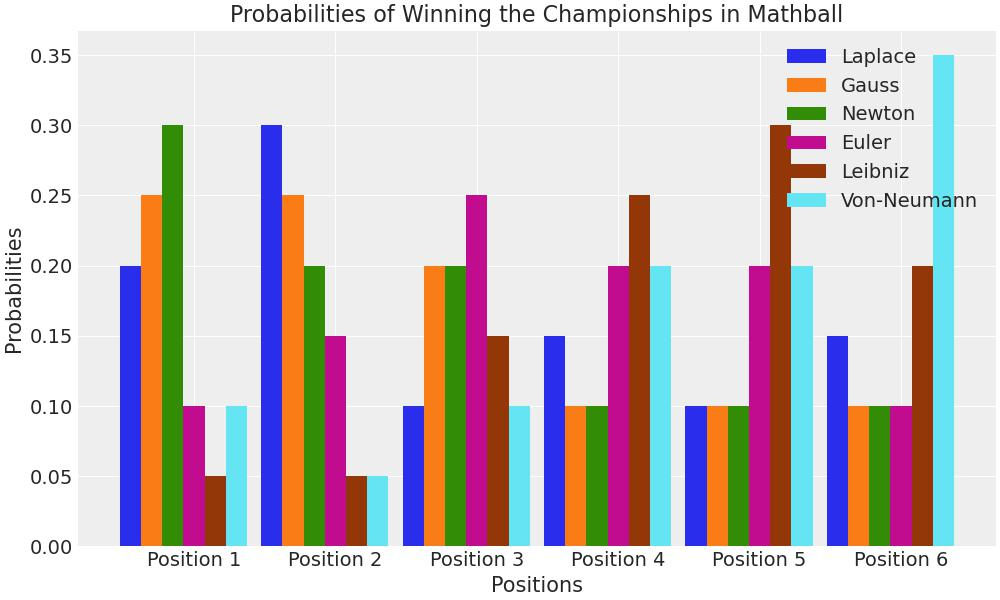

In [96]:
from IPython.display import Image, display
image_path = 'img_bar_chat.jpg'
display(Image(filename=image_path))

## Your code and answers here

The analysis of attack and defense strength HDI reveals that Euler emerges as the offensive best player, aligning with the high goal difference observed in Part 1. However, the defensive paints a different picture, with Leibniz showcasing the best defense despite having the worst offense. This view explains Leibniz's poor overall performance in Part 1, suggesting a team that excels at preventing goals but struggles to score them. Gauss presents an interesting case, with the worst defense but a strong offensive showing, indicating that their positive goal difference from Part 1 likely stems from exceptional scoring rather than defensive prowess. The performances of Newton, Von Neumann, and Laplace appear more balanced or consistent with earlier observations.

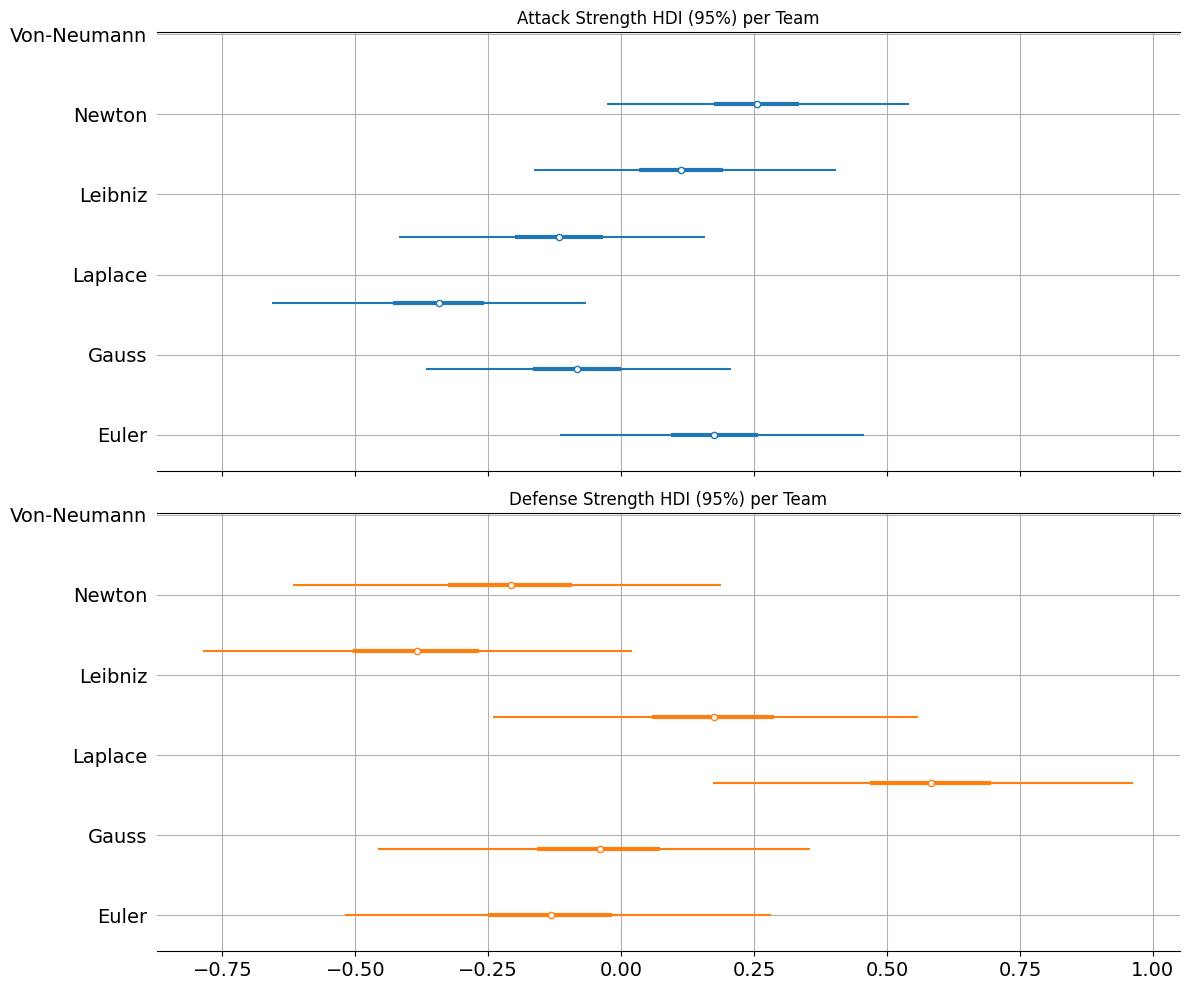

Best offense: Euler
Worst offense: Leibniz
Best defense: Leibniz
Worst defense: Gauss


In [97]:
# Task 1

# Extracting the  attack and defense strengths from the trace
att_samples = trace.posterior['att']
def_samples = trace.posterior['def']

# Graph
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Custom colors for attack and defense
colors = ["#1f77b4", "#ff7f0e"]

# Plot for attack strength
az.plot_forest(trace, var_names=['att'], hdi_prob=0.95, combined=True, colors=colors[0], ax=axs[0])
axs[0].set_title('Attack Strength HDI (95%) per Team')
axs[0].set_yticks(range(len(teams)))
axs[0].set_yticklabels(teams)
axs[0].grid(True)

# Plot for defense strength
az.plot_forest(trace, var_names=['def'], hdi_prob=0.95, combined=True, colors=colors[1], ax=axs[1])
axs[1].set_title('Defense Strength HDI (95%) per Team')
axs[1].set_yticks(range(len(teams)))
axs[1].set_yticklabels(teams)
axs[1].grid(True)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

# Identifying the best and worst offense and defense
att_mean = att_samples.mean(dim=("chain", "draw")).values
def_mean = def_samples.mean(dim=("chain", "draw")).values

best_offense_idx = att_mean.argmax()
worst_offense_idx = att_mean.argmin()
best_defense_idx = def_mean.argmax()
worst_defense_idx = def_mean.argmin()

best_offense = teams[best_offense_idx]
worst_offense = teams[worst_offense_idx]
best_defense = teams[best_defense_idx]
worst_defense = teams[worst_defense_idx]

print(f"Best offense: {best_offense}")
print(f"Worst offense: {worst_offense}")
print(f"Best defense: {best_defense}")
print(f"Worst defense: {worst_defense}")

In [98]:
# Task 2

# Extracting the samples for Euler and Gauss defense
def_euler = def_samples.sel(team='Euler')
def_gauss = def_samples.sel(team='Gauss')

# Calculating the probability
prob_euler_better_def = (def_euler > def_gauss).mean().values
print(f"Probability that Euler has a better defense than Gauss: {prob_euler_better_def:.2f}")

Probability that Euler has a better defense than Gauss: 0.98


In [99]:
from scipy.stats import poisson

# Extracting posterior samples from the trace
posterior = az.extract(trace)

# Defining a function to calculate the probabilities of game outcomes
# between a home team and an away team based on their attack and defense strengths, here the threshold is set to 20
# to answer the question of task 3
def calculate_game_probabilities(home_team, away_team, posterior, threshold=20):
    # Index for the home and away teas from the teams DataFrame
    home_idx = teams.get_loc(home_team)
    away_idx = teams.get_loc(away_team)
    
    # Calculating the expected goals (rate) for the home team by combining the model's parameters:
    # intercept, home advantage, attack strength of the home team, defense strength of the away team,
    # and adjusting for the average attack and defense strengths across all teams
    home_rate = np.exp(posterior['intercept'] + posterior['home'] + 
                       posterior['att'][:, home_idx] - posterior['att'].mean(axis=1) + 
                       posterior['def'][:, away_idx] - posterior['def'].mean(axis=1))
    
    # Calculating the expected goals (rate) for the away team in a similar manner,
    # but without the home advantage parameter
    away_rate = np.exp(posterior['intercept'] + 
                       posterior['att'][:, away_idx] - posterior['att'].mean(axis=1) + 
                       posterior['def'][:, home_idx] - posterior['def'].mean(axis=1))
    
    # Calculating the probability of the home team scoring more than 'threshold' goals
    # by using the Poisson distribution and taking the mean of the probabilities
    home_prob = (1 - poisson.cdf(threshold - 1, home_rate)).mean()
    
    # Calculating the probability of the away team scoring less than 'threshold' goals
    # in a similar manner
    away_prob = poisson.cdf(threshold - 1, away_rate).mean()
    
    return home_prob, away_prob

# Calculating and printing the probabilities for the specific game scenario of the task 3 question:
# Leibniz (home) vs Newton (away) and the probabilities of scoring more or less than 20 goals
leibniz_prob, newton_prob = calculate_game_probabilities('Leibniz', 'Newton', posterior)

print(f"Probability that Leibniz will score more than 20: {leibniz_prob:.2f}")
print(f"Probability that Newton will score less than 20: {newton_prob:.2f}")

Probability that Leibniz will score more than 20: 0.36
Probability that Newton will score less than 20: 0.90


Sampling: []


Output()

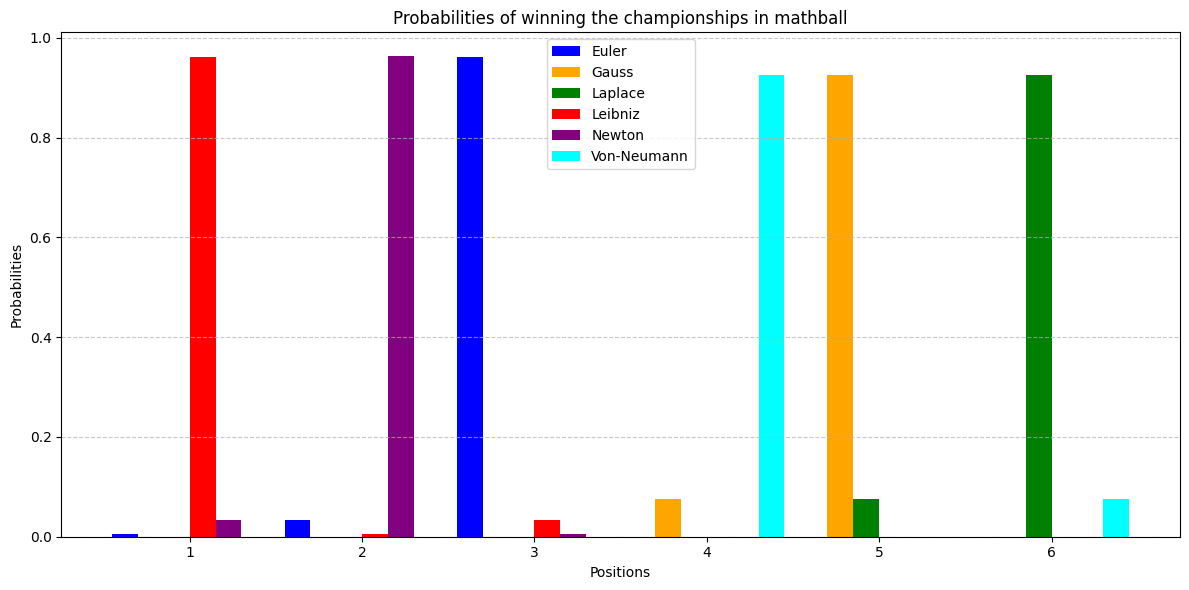

In [107]:

# Begin the simulation within the context of the Bayesian model
with mathball:
    # Generating posterior predictive samples for the likelihoods of outcomes 'theta_g1' and 'theta_g2'
    ppc = pm.sample_posterior_predictive(trace, var_names=["theta_g1", "theta_g2"], random_seed=42)

# Results matrix for the 4000 simulations
n_teams = len(teams)
results = np.zeros((4000, n_teams, n_teams), dtype=int)

# Iterating over each pair of teams to simulate the match outcomes
for i in range(n_teams):
    for j in range(n_teams):
        if i != j:
            # Extracting the simulated scores for the home and away teams from the posterior predictive samples
            home_goals = ppc.posterior_predictive["theta_g1"][:, :, home_idx][0, :, i]
            away_goals = ppc.posterior_predictive["theta_g2"][:, :, away_idx][0, :, j]

            # Comparing the scores for each of the 4000 simulations to determine the match outcome
            for k in range(4000):
                if home_goals[k] > away_goals[k]:
                    results[k, i, j] = 3  # Home team wins and receives 3 points
                elif home_goals[k] == away_goals[k]:
                    results[k, i, j] = 1  # The match is a draw; both teams receive 1 point
                else:
                    results[k, i, j] = 0  # Home team loses and receives 0 points

# Sum of the points and ranks for each team
points = results.sum(axis=2)
ranks = points.argsort(axis=1).argsort(axis=1) + 1

# Calculating the probability of each team finishing in each rank position
rank_probs = np.zeros((n_teams, n_teams))
for i in range(n_teams):
    for j in range(n_teams):
        rank_probs[i, j] = (ranks[:, i] == j+1).mean() # Probability matrix

# Number of teams and the positions for the x-axis of the bar chart
positions = range(1, n_teams + 1)

plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan']

# Probability bars for each team
bar_width = 0.15
for i, team in enumerate(teams):
    offset = (i - (n_teams - 1) / 2) * bar_width
    plt.bar([p + offset for p in positions], rank_probs[i], 
            width=bar_width, label=team, color=colors[i % len(colors)])

plt.xlabel('Positions')
plt.ylabel('Probabilities')
plt.title('Probabilities of winning the championships in mathball')
plt.xticks(positions)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
